**6820017_ArimitraMaiti_IA1**

### <center>Tripadvisor Review Multinomial Classification in Jupyter (Part-II)</center>
<center>Big Data Analytics - Analysis of Text and Social Media Data: Individual Assignment Week-3</center>
<center>ePGD ABA 2020-21</center>

**Second notebook for data analysis and model building**

**CAUTION - This notebook takes roughly 25 minutes to complete execution (excluding model train) \
This notebook may not run end to end in google colab environment or mac environment \
The input file for this notebook comes from the output of the first notebook**

In [1]:
###Need to use nltk download commands for the first time to set up the machine
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [2]:
##Import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import math
import sys

In [3]:
import string
import re

In [4]:
# !pip install wordcloud
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# conda config --add channels conda-forge
# conda install pyahocorasick
# !pip install contractions
import contractions

In [7]:
from nltk.corpus import wordnet

In [8]:
# !pip install textblob
from textblob import TextBlob

In [9]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [10]:
##Import review data obtained from tripadvisor crawler
# dataset = pd.read_csv("reviews_mainland_china.csv", parse_dates=True, usecols=['score', 'date', 'title', 'review',
#                                                                               'link_id', 'Name', 'Location', 'City'])
# dataset.head()

In [11]:
##Import review data obtained from tripadvisor crawler
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/articles/reviews_mainland_china.csv"
dataset = pd.read_csv(url, error_bad_lines = False, header=0, index_col=None, parse_dates=True, 
                      usecols=['score', 'date', 'title', 'review', 'link_id', 'Name', 'Location', 'City'])
dataset.head(4)

,score,date,title,review,link_id,Name,Location,City
0,30,30 August 2020,Gets the job done,Decent indo chinese food and good buffet optio...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Panaji,Goa
1,40,27 January 2019,Good chinese food,We visited this restaurant for lunch with frie...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Panaji,Goa
2,40,12 September 2018,Chinese food,Mainland China has maintained its quality of C...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Panaji,Goa
3,50,21 August 2018,Brilliant experience,I looved it absolutelyMy first buffet in goa n...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Panaji,Goa


In [12]:
##Sort data by date of review
dataset = dataset.sort_values(by=['date'], ascending=False)

In [13]:
##Reset index
dataset = dataset.reset_index(drop="index")

In [14]:
dataset.head()

,score,date,title,review,link_id,Name,Location,City
0,50,9 September 2015,The taste of China,For me Chinese means Mainland China at Kolkata...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Ballygunje,Kolkata
1,30,9 September 2015,Dinner at mainland China at Sector 29- Deficit...,Have regulary visited 'Mainland china' at Sect...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Raliance Mart,Gurugram
2,40,9 September 2015,Good Authentic Chinese food,Worth going there. food is really good and app...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Genda Circle,Vadodara
3,40,9 September 2015,Pooja maheshwari,If you want Chinese cuisine experience without...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Andheri,Mumbai
4,30,9 September 2015,Nice ambience but so-so food,The décor is nice and the staff is friendly. S...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Andheri,Mumbai


In [15]:
##Check for missing values in the dataset
dataset.isnull().sum()/dataset.shape[0] * 100

score       0.0
date        0.0
title       0.0
review      0.0
link_id     0.0
Name        0.0
Location    0.0
City        0.0
dtype: float64

In [16]:
##Map bubble rating score to 3 classes, 1 having score 10 & 20, 2 having score 30, 3 having score of 40 & 50 
score_mapping = {10:0, 20:0, 30:1, 40:2, 50:2}
dataset["target"] = dataset.score.map(score_mapping)

In [17]:
dataset.target.value_counts().sort_index()

0     240
1     519
2    3232
Name: target, dtype: int64

In [18]:
dataset.score.value_counts().sort_index()

10      95
20     145
30     519
40    1791
50    1441
Name: score, dtype: int64

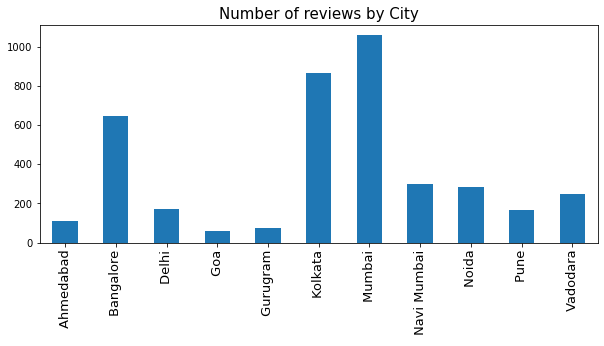

In [19]:
##Number of reviews collected per city
dataset['City'].value_counts().sort_index().plot(kind='bar', figsize=(10,4));
plt.title('Number of reviews by City', fontsize=15)
plt.xticks(fontsize=13)
plt.show()

In [20]:
##This function must have the corpus, custom stop list, maximum word list, topN word counts and word cloud title
def my_wordcloud(file, my_stop_list, maxwords=100, top_n=50, source="ABC"):
    raw = file.lower()
    tokens = nltk.word_tokenize(raw)
    token_list = nltk.Text(tokens)
    ##Initialize stemmer and lemmatizer
    ps = PorterStemmer()
    ls = WordNetLemmatizer()
    
    ##Use stopwords of nltk, punctuations from string module and some custom words
    stop_set = set(nltk.corpus.stopwords.words('english'))
    stop_punctuation = set(list(string.punctuation))
    stop_set.update(stop_punctuation)
    stop_set.update(my_stop_list)
    
    ##Not sure if this is working to replace apostophe!
    token_list = [i.replace("'","").replace('"', '') for i in token_list]
    ##Remove stopwords and punctuation
    token_list = [i for i in token_list if i not in stop_set]
    ##Remove numbers, however it is not removing everything
    token_list = [c for c in token_list if not c.isnumeric()]
    ##Use lemmatizer first
    token_list = [ls.lemmatize(w) for w in token_list]
    
    token_list = [i for i in token_list if i not in my_stop_list]
    token_list = [item.replace('’', "") for item in token_list]
    token_list = [item.replace('–', "") for item in token_list]
    token_list = [i for i in token_list if i]
    
    bigrams_list = list(nltk.bigrams(token_list))
    dictionary2 = [' '.join(tup) for tup in bigrams_list]
    
    #Using count vectoriser to view the frequency of bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(dictionary2)
    vectorizer.vocabulary_
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    ##Plot word cloud
    wc = WordCloud(max_words=maxwords, max_font_size=30, background_color='white').generate(' '.join(token_list))
    plt.figure(figsize = (30,6))
    plt.imshow(wc)
    plt.title(f"Top {maxwords} words from {source} for wordcloud")
    plt.show()
    
   
    
    words_dict = dict(words_freq)
    wordCloud = WordCloud(max_words=maxwords, stopwords=my_stop_list, max_font_size=30, background_color='white')
    wordCloud.generate_from_frequencies(words_dict)
    plt.figure(figsize = (30,6))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.title(f"Top {maxwords} bigrams from {source} for wordcloud")
    plt.show()
    
    ##Plot barplot
    w, cnt = list(wc.words_.keys()), list(wc.words_.values())
    topn = top_n
    plt.figure(figsize=(16,6))
    plt.bar(w[:topn], cnt[:topn])
    plt.title(f"Top {top_n} words from {source}")
    p=plt.xticks(rotation=60)
    
    print(' '.join(w))

In [21]:
target_1 = dataset.loc[dataset.target==0, ["title"]]
target_1_corpus = (' '.join(target_1['title']))

target_1.shape

(240, 1)

In [22]:
my_stop_list1 = ['mainland', 'china', 'chinese', 'food', 'dish', 'dishes', 'foodie', 'dine', 'dining', 'one', 'ok', 'okay']

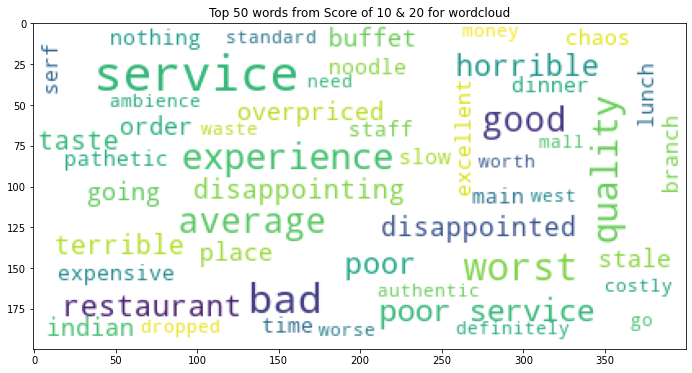

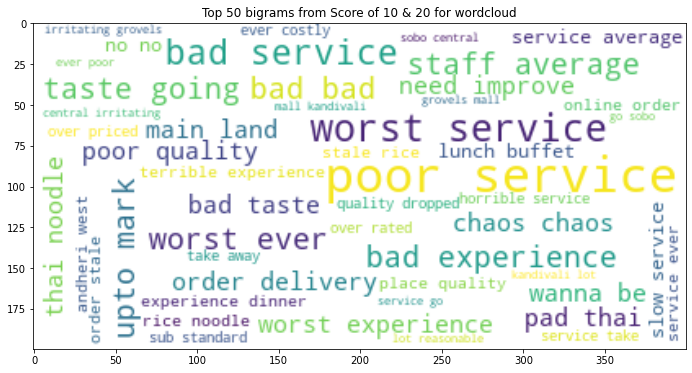

service bad worst quality experience good average poor service poor restaurant horrible taste disappointing terrible disappointed order indian overpriced place buffet going stale chaos slow serf excellent main noodle pathetic expensive branch lunch time nothing dinner staff go mall definitely worth money authentic worse need west standard dropped costly waste ambience


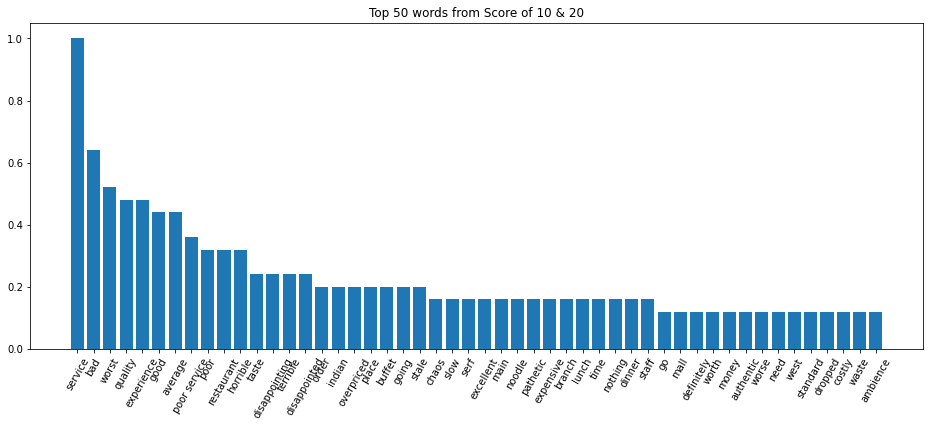

In [23]:
##Wordcloud for score 10 & 20, i.e. target class=1
my_wordcloud(target_1_corpus, my_stop_list=my_stop_list1, maxwords=50, top_n=50, source="Score of 10 & 20")

In [24]:
target_2 = dataset.loc[dataset.target==1, ["title"]]
target_2_corpus = (' '.join(target_2['title']))

target_2.shape

(519, 1)

In [25]:
my_stop_list2 = ['mainland', 'china', 'chinese', 'food', 'dish', 'dishes', 'foodie', 'dine', 'dining', 'one', 'ok', 'okay']

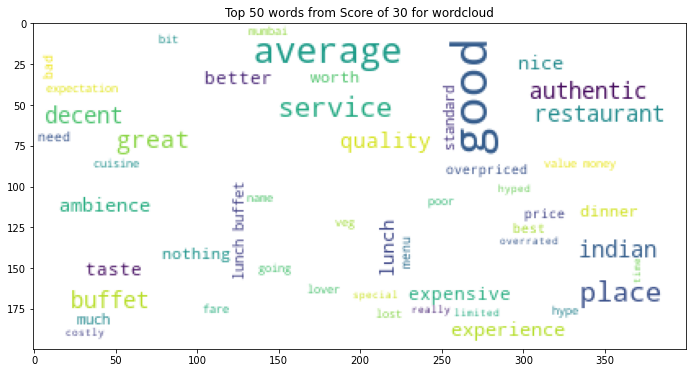

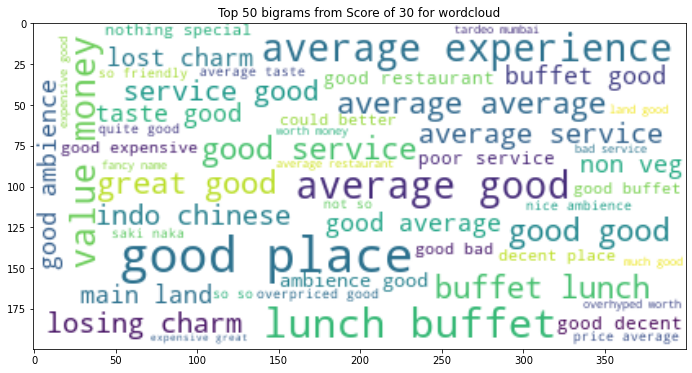

good average place service great authentic restaurant buffet decent indian quality experience nice ambience lunch taste better expensive dinner nothing worth much standard lunch buffet overpriced price best menu bad need veg going bit poor hype lost name mumbai fare cuisine lover expectation value money really special limited time overrated hyped costly


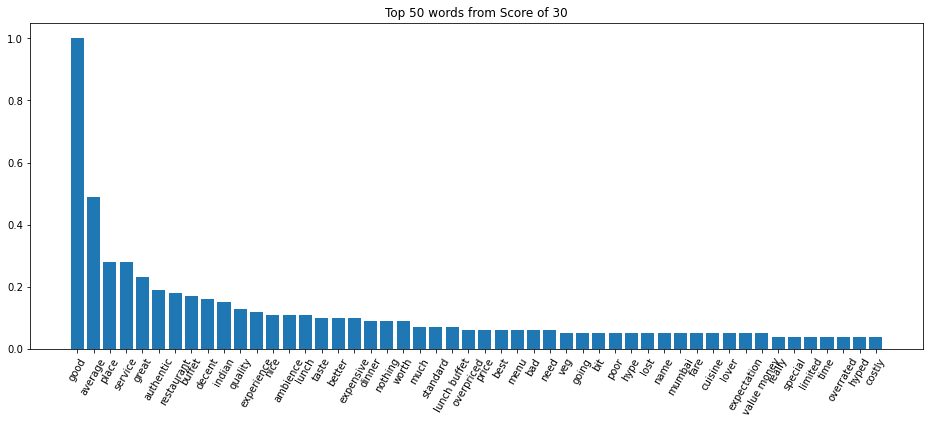

In [26]:
##Wordcloud for score 30, i.e. target class=2
my_wordcloud(target_2_corpus, my_stop_list=my_stop_list2, maxwords=50, top_n=50, source="Score of 30")

In [27]:
target_3 = dataset.loc[dataset.target==2, ["title"]]
target_3_corpus = (' '.join(target_3['title']))

target_3.shape

(3232, 1)

In [28]:
my_stop_list3 = ['mainland', 'china', 'chinese', 'food', 'dish', 'dishes', 'foodie', 'dine', 'dining', 'one', 'ok', 'okay']

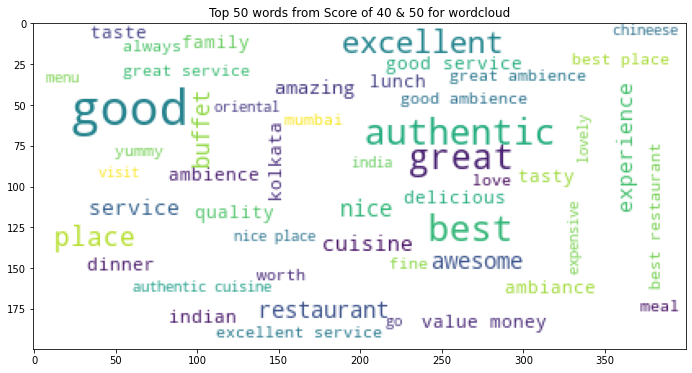

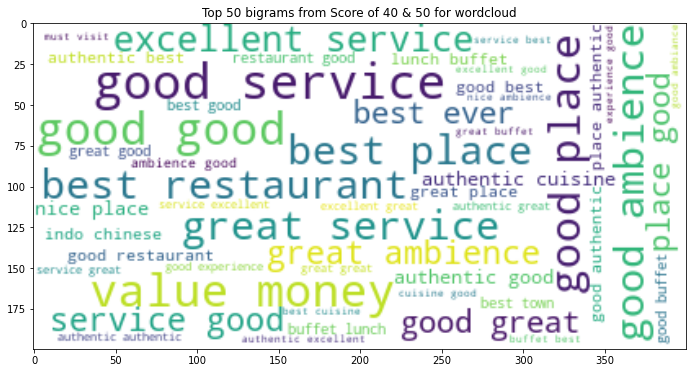

good authentic best great excellent place restaurant awesome buffet nice service experience cuisine amazing delicious indian dinner good service kolkata taste ambience lunch tasty value money ambiance family quality love yummy great service best place always best restaurant good ambience meal worth fine excellent service great ambience mumbai visit expensive authentic cuisine menu india oriental nice place lovely go chineese


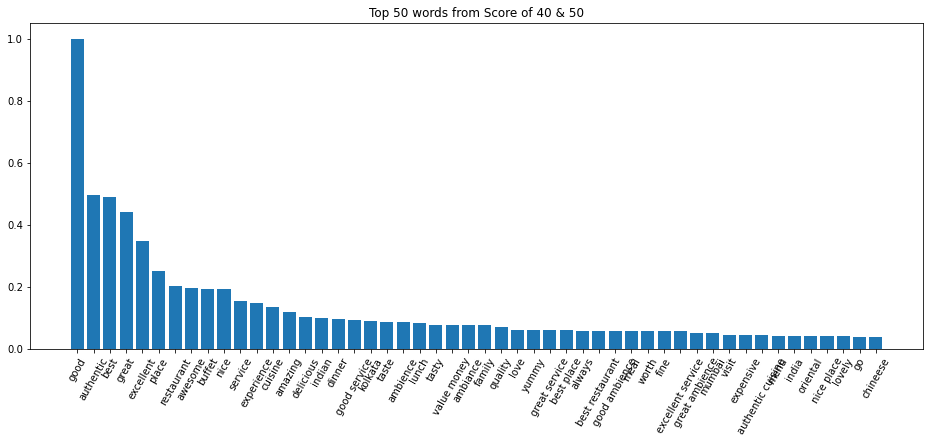

In [29]:
##Wordcloud for score 40 & 50, i.e. target class=3
my_wordcloud(target_3_corpus, my_stop_list=my_stop_list3, maxwords=50, top_n=50, source="Score of 40 & 50")

In [30]:
my_stop_list4 = ['mainland', 'china', 'chinese', 'food', 'dish', 'dishes', 'foodie', 'dine', 'dining', 'one', 'ok', 'okay']

In [31]:
##Use contractions
dataset['review_modified'] = dataset['review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
##convert list to string
dataset['review_modified_unlist'] = [' '.join(map(str, l)) for l in dataset['review_modified']]
##convert string to tokens
dataset['review_mod_tokens'] = dataset['review_modified_unlist'].apply(nltk.word_tokenize)
##convert token to lower case
dataset['review_mod_tokens'] = dataset['review_mod_tokens'].apply(lambda x: [word.lower() for word in x])
##remove punctuations
dataset['review_mod_tokens'] = dataset['review_mod_tokens'].apply(lambda x: [word for word in x if word not in string.punctuation])
stop_set = set(nltk.corpus.stopwords.words('english'))
stop_set.update(my_stop_list4)
##remove default and custom stop words
dataset['review_mod_tokens'] = dataset['review_mod_tokens'].apply(lambda x: [word for word in x if word not in stop_set])
##extract parts of speech tags
dataset['review_tags'] = dataset['review_mod_tokens'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
dataset['review_wordnet'] = dataset['review_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
##use lemmatizer on parts of speech tags
lm = WordNetLemmatizer()
dataset['review_lemmatized'] = dataset['review_wordnet'].apply(lambda x: [lm.lemmatize(word, tag) for word, tag in x])
dataset = dataset[['score', 'date', 'title', 'link_id', 'Name', 'Location', 'City', 'target', 'review_lemmatized']]

dataset['review_str'] = [' '.join(map(str,l)) for l in dataset['review_lemmatized']]
##extract sentiment score from parts of speech tags
dataset['sentiment_score'] = dataset['review_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

dataset.head()

,score,date,title,link_id,Name,Location,City,target,review_lemmatized,review_str,sentiment_score
0,50,9 September 2015,The taste of China,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Ballygunje,Kolkata,2,"[mean, kolkata, group, well, go, buffet, judge...",mean kolkata group well go buffet judge name s...,0.148958
1,30,9 September 2015,Dinner at mainland China at Sector 29- Deficit...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Raliance Mart,Gurugram,1,"[regulary, visit, 'mainland, sector, 29, famil...",regulary visit 'mainland sector 29 family natu...,0.160034
2,40,9 September 2015,Good Authentic Chinese food,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Genda Circle,Vadodara,2,"[worth, go, really, good, appealing, also, lov...",worth go really good appealing also love servi...,0.540000
3,40,9 September 2015,Pooja maheshwari,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Andheri,Mumbai,2,"[want, cuisine, experience, without, visit, pl...",want cuisine experience without visit place be...,0.166667
4,30,9 September 2015,Nice ambience but so-so food,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Andheri,Mumbai,1,"[décor, nice, staff, friendly, item, menu, usu...",décor nice staff friendly item menu usual run ...,0.130556


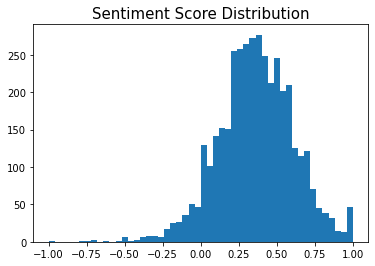

In [32]:
##Histogram plot of sentiment score
plt.hist(dataset['sentiment_score'], bins=50);
plt.title('Sentiment Score Distribution', fontsize=15)
plt.show()

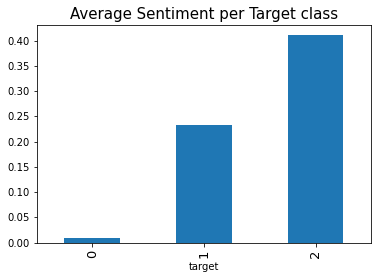

In [33]:
##Average sentiment score for each target class
dataset.groupby('target')['sentiment_score'].mean().plot(kind='bar', figsize=(6,4));
plt.title('Average Sentiment per Target class', fontsize=15)
plt.xticks(fontsize=13)
plt.show()

In [34]:
dataset['word_count'] = dataset['review_lemmatized'].apply(lambda x: len(str(x).split()))
dataset['review_length'] = dataset['review_str'].astype(str).apply(len)

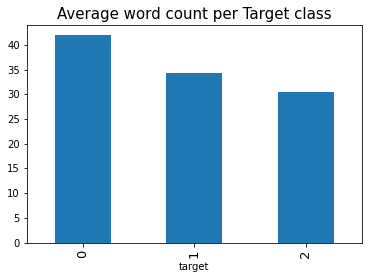

In [35]:
##Average word count for each target class
dataset.groupby('target')['word_count'].mean().plot(kind='bar', figsize=(6,4));
plt.title('Average word count per Target class', fontsize=15)
plt.xticks(fontsize=13)
plt.show()

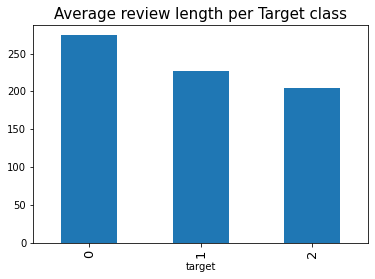

In [36]:
##Average length of comments for each target class
dataset.groupby('target')['review_length'].mean().plot(kind='bar', figsize=(6,4));
plt.title('Average review length per Target class', fontsize=15)
plt.xticks(fontsize=13)
plt.show()

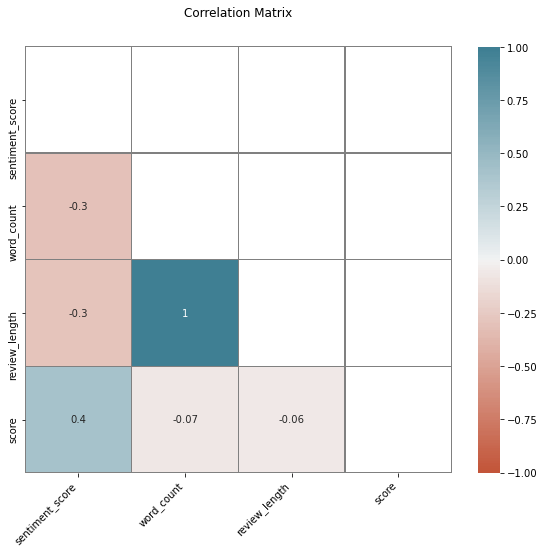

In [37]:
##Correlation matrix of derived features
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cormat = dataset[['sentiment_score', 'word_count', 'review_length', 'score']].corr()
sns.heatmap(cormat, 
            cmap=sns.diverging_palette(20, 220, n=200),
            fmt='.1g',
            annot = True,
            annot_kws={"size": 10},
            cbar_kws={"shrink": .82},
            vmin=-1, vmax=1, center= 0,
            linewidths=0.5,
            rasterized=False,
            linecolor='grey',
            square=True,
            mask=np.triu(cormat),
            ax=ax)
ax.set_title('Correlation Matrix', fontsize=12, pad=30)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
fig.tight_layout()
plt.show()

In [38]:
##Process to extract LDA topics
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(dataset['review_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))

lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
chicken rice noodle sauce fry fish prawn try soup dumpling
Topic 1:
buffet good money restaurant value lunch service quality carte great
Topic 2:
good buffet lunch staff place service also nice great tasty
Topic 3:
go city serve come order take dinner like even starter
Topic 4:
time visit go restaurant service outlet year experience day never
Topic 5:
table place get would make wait could eat menu ask
Topic 6:
good service place great ambience staff quality family nice excellent
Topic 7:
veg starter main course non soup dessert ice buffet good
Topic 8:
preparation something meal give charge specially dimsum provide nice tax
Topic 9:
place taste authentic restaurant best love visit great cuisine try


In [39]:
lda_topic_values = lda_model.transform(tf)
dataset['lda_topic_id'] = lda_topic_values.argmax(axis=1)

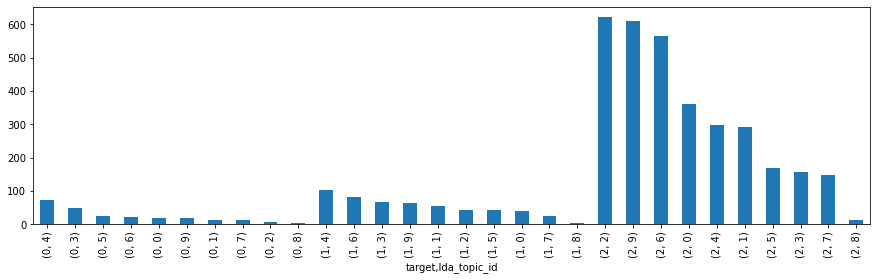

In [40]:
##Plot LDA topics to each row of the dataset and check distribution for each target class
dataset.groupby('target')['lda_topic_id'].value_counts().plot(kind='bar', figsize=(15,4));

In [41]:
dataset.columns

Index(['score', 'date', 'title', 'link_id', 'Name', 'Location', 'City',
       'target', 'review_lemmatized', 'review_str', 'sentiment_score',
       'word_count', 'review_length', 'lda_topic_id'],
      dtype='object')

In [42]:
dataset_model = dataset[['target', 'review_str', 'Location', 'City', 'word_count', 'lda_topic_id']]

In [43]:
# !python -m pip install -U gensim

In [44]:
###First time download may take upto 30 minutes
##Download google word2vec pre trained model from gensim
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [45]:
##Create unique set of words from google model
vocabulary = set(wv.index2word)

In [46]:
##Dimension of each word
embedding_size = wv.vector_size

In [47]:
print("Model contains %d words" %len(vocabulary))

Model contains 3000000 words


In [48]:
print("Each word is represented by a %d dimensional vector" %embedding_size)

Each word is represented by a 300 dimensional vector


In [49]:
##Create X and y attrs, X here has only one column from the explicit dataset
##We are yet to form the features
X, y = dataset_model['review_str'], dataset_model[['target']]
X.shape, y.shape

((3991,), (3991, 1))

In [50]:
##Define word2vec function where mean of the vectors would be considered if the word exists Else zero
def mean_vector(review):
    zero = np.zeros((embedding_size,), dtype="float32")
    if pd.isnull(review):
        return zero
    words = [w for w in review.split() if w in vocabulary]
    if not words:
        return zero
    return np.mean([wv[w] for w in words], axis=0)

In [51]:
cols = ['v_'+str(i) for i in range(embedding_size)]

In [52]:
dfV = pd.DataFrame(list(map(mean_vector, X)), columns=cols)

In [53]:
X, y = dfV, y
X.shape, y.shape

((3991, 300), (3991, 1))

In [54]:
add_features = dataset_model[['Location', 'City', 'word_count', 'lda_topic_id']]

In [55]:
X_new = pd.concat([add_features, X], axis=1)
X_new.shape, y.shape

((3991, 304), (3991, 1))

In [56]:
X_new['lda_topic_id'] = X_new['lda_topic_id'].astype('O')

In [57]:
# !pip install scikit-multilearn

import skmultilearn
from skmultilearn.model_selection import iterative_train_test_split

In [58]:
from skmultilearn.model_selection import IterativeStratification

def iterative_train_test_split(X, y, test_size):
    stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, y))

    X_train, y_train = X.iloc[train_indexes], y[train_indexes, :]
    X_test, y_test = X.iloc[test_indexes], y[test_indexes, :]

    return X_train, y_train, X_test, y_test

In [59]:
result = iterative_train_test_split(X_new, y[['target']].values, 0.20)

In [60]:
X_data = result[0]
X_test = result[2]

In [61]:
X_data.shape, X_test.shape

((3192, 304), (799, 304))

In [62]:
y_data = result[1]
y_test = result[3]
y_data.shape, y_test.shape

((3192, 1), (799, 1))

In [63]:
print(f"Proportion for Target class:0 is {round((np.unique(y_data, return_counts=True)[1][0]/y_data.shape[0])*100,2)} percent in X_data")
print(f"Proportion for Target class:1 is {round((np.unique(y_data, return_counts=True)[1][1]/y_data.shape[0])*100,2)} percent in X_data")
print(f"Proportion for Target class:2 is {round((np.unique(y_data, return_counts=True)[1][2]/y_data.shape[0])*100,2)} percent in X_data")

Proportion for Target class:0 is 5.98 percent in X_data
Proportion for Target class:1 is 13.28 percent in X_data
Proportion for Target class:2 is 80.73 percent in X_data


In [64]:
y_data = pd.DataFrame(y_data, columns=['target'])

In [65]:
result_repeat = iterative_train_test_split(X_data, y_data[['target']].values, 0.20)

In [66]:
X_train = result_repeat[0]
X_valid = result_repeat[2]
X_train.shape, X_valid.shape

((2553, 304), (639, 304))

In [67]:
y_train = result_repeat[1]
y_valid = result_repeat[3]
y_train.shape, y_valid.shape

((2553, 1), (639, 1))

In [68]:
print(f"Proportion for Target class:0 is {round((np.unique(y_train, return_counts=True)[1][0]/y_train.shape[0])*100,2)} percent in train set")
print(f"Proportion for Target class:1 is {round((np.unique(y_train, return_counts=True)[1][1]/y_train.shape[0])*100,2)} percent in train set")
print(f"Proportion for Target class:2 is {round((np.unique(y_train, return_counts=True)[1][2]/y_train.shape[0])*100,2)} percent in train set")

Proportion for Target class:0 is 5.95 percent in train set
Proportion for Target class:1 is 13.44 percent in train set
Proportion for Target class:2 is 80.61 percent in train set


In [69]:
print(f"Proportion for Target class:0 is {round((np.unique(y_valid, return_counts=True)[1][0]/y_valid.shape[0])*100,2)} percent in validation set")
print(f"Proportion for Target class:1 is {round((np.unique(y_valid, return_counts=True)[1][1]/y_valid.shape[0])*100,2)} percent in validation set")
print(f"Proportion for Target class:2 is {round((np.unique(y_valid, return_counts=True)[1][2]/y_valid.shape[0])*100,2)} percent in validation set")

Proportion for Target class:0 is 6.1 percent in validation set
Proportion for Target class:1 is 12.68 percent in validation set
Proportion for Target class:2 is 81.22 percent in validation set


In [70]:
print(f"Proportion for Target class:0 is {round((np.unique(y_test, return_counts=True)[1][0]/y_test.shape[0])*100,2)} percent in test set")
print(f"Proportion for Target class:1 is {round((np.unique(y_test, return_counts=True)[1][1]/y_test.shape[0])*100,2)} percent in test set")
print(f"Proportion for Target class:2 is {round((np.unique(y_test, return_counts=True)[1][2]/y_test.shape[0])*100,2)} percent in test set")

Proportion for Target class:0 is 6.13 percent in test set
Proportion for Target class:1 is 11.89 percent in test set
Proportion for Target class:2 is 81.98 percent in test set


In [71]:
y_train = pd.DataFrame(y_train, columns=['target'])
y_valid = pd.DataFrame(y_valid, columns=['target'])
y_test = pd.DataFrame(y_test, columns=['target'])

In [72]:
##check if any numerical features have any constant variance, i.e. standard deviation as zero
store = []
for i in range(len(X_train.columns)):
    if X_train[X_train.columns[i]].dtype != 'object':
        varname = X_train.columns[i]
        store.append(varname)

constant_features = [x for x in store if X_train[x].std() == 0]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_valid.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

print(X_train.shape, X_valid.shape, X_test.shape)

(2553, 304) (639, 304) (799, 304)


C:\Users\sinaii\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [73]:
del store

In [74]:
# create an empty list
quasi_constant_feat = []

# iterate over every attributes in the train set including numerical and object variables
for k in X_train.columns:
    # find the dominant value, that is the value that is shared by most observations
    predominant = (X_train[k].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the dominant feature: do more than 99% of the observations show 1 single value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(k)

len(quasi_constant_feat)

0

In [75]:
quasi_constant_feat

[]

In [76]:
X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_valid.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

print(X_train.shape, X_valid.shape, X_test.shape)

(2553, 304) (639, 304) (799, 304)


In [77]:
##Check if we have features that despite having different names, are identical.
# check for duplicated features in the training set:

# create an empty dictionary, where we will store 
# the groups of duplicates
duplicated_feat_pairs = {}

# create an empty list to collect features
# that were found to be duplicated
_duplicated_feat = []


# iterate over every feature in our dataset:
for i in range(0, len(X_train.columns)):
    
    # this bit helps me understand where the loop is at:
    if i % 10 == 0:  
        print(i)
    
    # choose 1 feature:
    feat_1 = X_train.columns[i]
    
    # check if this feature has already been identified
    # as a duplicate of another one. If it was, it should be stored in
    # our _duplicated_feat list.
    
    # If this feature was already identified as a duplicate, we skip it, if
    # it has not yet been identified as a duplicate, then we proceed:
    if feat_1 not in _duplicated_feat:
    
        # create an empty list as an entry for this feature in the dictionary:
        duplicated_feat_pairs[feat_1] = []

        # now, iterate over the remaining features of the dataset:
        for feat_2 in X_train.columns[i + 1:]:

            # check if this second feature is identical to the first one
            if X_train[feat_1].equals(X_train[feat_2]):

                # if it is identical, append it to the list in the dictionary
                duplicated_feat_pairs[feat_1].append(feat_2)
                
                # and append it to our monitor list for duplicated variables
                _duplicated_feat.append(feat_2)
                
                # done!

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


In [78]:
## If length is positive then we do have some duplicated features
len(_duplicated_feat)
# duplicated_feat_pairs

0

In [79]:
import xgboost as xgb
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, f1_score

In [80]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingClassifier

In [81]:
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

In [82]:
rare_label_encoder = RareLabelCategoricalEncoder(tol=0.01, n_categories=5,
                                                 variables=['Location', 'City', 'lda_topic_id'])

In [83]:
rare_label_encoder.fit(X_train)
X_train_rlc = rare_label_encoder.transform(X_train)
X_valid_rlc = rare_label_encoder.transform(X_valid)
X_test_rlc = rare_label_encoder.transform(X_test)

In [84]:
ordered_label_encoder = OrdinalCategoricalEncoder(
    encoding_method='ordered',
    variables=['Location', 'City', 'lda_topic_id'])

In [85]:
##Fit the transformer in trainset for both predictors and target labels, this is outside the above pipeline
ordered_label_encoder.fit(X_train_rlc, y_train)

OrdinalCategoricalEncoder(variables=['Location', 'City', 'lda_topic_id'])

In [86]:
##Fit the transformer to train, validation and test sets
X_train1 = ordered_label_encoder.transform(X_train_rlc)
X_valid1 = ordered_label_encoder.transform(X_valid_rlc)
X_test1 = ordered_label_encoder.transform(X_test_rlc)

In [87]:
del X_train, X_valid, X_test

In [88]:
X_train = X_train1.copy()
X_valid = X_valid1.copy()
X_test = X_test1.copy()

In [89]:
X_train.shape, X_valid.shape, X_test.shape

((2553, 304), (639, 304), (799, 304))

In [90]:
sns.set(font_scale = 1)

In [91]:
#SelectFromModel using Light GBM
# sel_ = SelectFromModel(
#     LGBMClassifier(boosting_type ="gbdt", objective = "multiclass",
#                    n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
#                    reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40,
#                    class_weight='balanced'
#                    ))

# sel_.fit(X_train, y_train.values.flatten())

# selected_attr_m1 = X_train.columns[(sel_.get_support())]

# len(selected_attr_m1)

# pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
# plt.xlabel('Feature importance')
# plt.ylabel('Number of Features')
# plt.show()

# print('total features: {}'.format((X_train.shape[1])))

# print('selected features: {}'.format(len(selected_attr_m1)))

# print(
#     'features with importance greater than the mean importance of all features: {}'.format(
#         np.sum(sel_.estimator_.feature_importances_ >
#                sel_.estimator_.feature_importances_.mean())))

# selected_attr_m1

In [92]:
##Somehow sns.set(font_scale = 5) is giving clear images of feature importance but resettig other plot options
# def plotImp(model, X , num = 20, text="ABC"):
#     feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
#     plt.figure(figsize=(40, 20))
#     sns.set(font_scale = 5)
#     sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
#                                                         ascending=False)[0:num])
#     plt.title(text)
#     plt.tight_layout()
#     plt.show()

In [93]:
# plotImp(sel_.estimator_, X_train, num=20, text='SelectFromModel-Light GBM')

In [94]:
#RFECV using Light GBM
# sel_ = RFECV(LGBMClassifier(boosting_type ="gbdt", objective = "multiclass", 
#                             n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2, 
#                             reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40, random_state=10, class_weight='balanced'
#                    ),
#              min_features_to_select=10, step=5, scoring="f1_micro")

# sel_.fit(X_train, y_train.values.flatten())

# selected_attr_m2 = X_train.columns[(sel_.get_support())]
# len(selected_attr_m2)

In [95]:
# list1 = selected_attr_m1
# list2 = selected_attr_m2

In [96]:
# big_list = [list1, list2]

# result = [item for sublist in big_list for item in sublist]

# result = pd.DataFrame(result, columns=['items'])

# result = result.sort_values(by=['items'], ascending=False)

# result = result['items'].value_counts()>1

# result = pd.DataFrame(result)

# algo_features = result[result['items']==True].index.tolist()

In [97]:
###Obtained from RFECV using LightGBM
list2 = ['Location', 'City', 'word_count', 'lda_topic_id', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
         'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_15', 'v_16', 'v_17', 'v_18', 'v_19', 'v_20', 'v_21', 'v_22', 'v_23',
         'v_24', 'v_25', 'v_26', 'v_27', 'v_28', 'v_29', 'v_30', 'v_31', 'v_32', 'v_33', 'v_34', 'v_35', 'v_36', 'v_37',
         'v_38', 'v_39', 'v_40', 'v_41', 'v_42', 'v_43', 'v_44', 'v_45', 'v_46', 'v_47', 'v_48', 'v_49', 'v_50', 'v_51',
         'v_52', 'v_53', 'v_54', 'v_55', 'v_56', 'v_57', 'v_58', 'v_59', 'v_60', 'v_61', 'v_62', 'v_63', 'v_64', 'v_65',
         'v_66', 'v_67', 'v_68', 'v_69', 'v_70', 'v_71', 'v_72', 'v_73', 'v_74', 'v_75', 'v_76', 'v_77', 'v_78', 'v_79',
         'v_80', 'v_81', 'v_82', 'v_83', 'v_84', 'v_85', 'v_86', 'v_87', 'v_88', 'v_89', 'v_90', 'v_91', 'v_92', 'v_93',
         'v_94', 'v_95', 'v_96', 'v_97', 'v_98', 'v_99', 'v_100', 'v_101', 'v_102', 'v_103', 'v_104', 'v_105', 'v_106',
         'v_107', 'v_108', 'v_109', 'v_110', 'v_111', 'v_112', 'v_113', 'v_114', 'v_115', 'v_116', 'v_117', 'v_118', 'v_119',
         'v_120', 'v_121', 'v_122', 'v_123', 'v_124', 'v_125', 'v_126', 'v_127', 'v_128', 'v_129', 'v_130', 'v_131', 'v_132',
         'v_133', 'v_134', 'v_135', 'v_136', 'v_137', 'v_138', 'v_139', 'v_141', 'v_142', 'v_143', 'v_144', 'v_145', 'v_146',
         'v_147', 'v_148', 'v_149', 'v_150', 'v_151', 'v_152', 'v_153', 'v_154', 'v_155', 'v_156', 'v_157', 'v_158', 'v_159',
         'v_160', 'v_161', 'v_162', 'v_163', 'v_164', 'v_165', 'v_166', 'v_167', 'v_168', 'v_169', 'v_170', 'v_171', 'v_172',
         'v_173', 'v_174', 'v_175', 'v_176', 'v_177', 'v_178', 'v_179', 'v_180', 'v_181', 'v_182', 'v_183', 'v_184', 'v_185',
         'v_186', 'v_187', 'v_188', 'v_189', 'v_190', 'v_191', 'v_192', 'v_193', 'v_194', 'v_195', 'v_196', 'v_197', 'v_198',
         'v_199', 'v_200', 'v_201', 'v_202', 'v_203', 'v_204', 'v_205', 'v_207', 'v_208', 'v_209', 'v_210', 'v_211', 'v_212',
         'v_213', 'v_214', 'v_216', 'v_217', 'v_218', 'v_219', 'v_220', 'v_221', 'v_222', 'v_223', 'v_224', 'v_225', 'v_226', 
         'v_227', 'v_228', 'v_229', 'v_230', 'v_231', 'v_232', 'v_233', 'v_234', 'v_235', 'v_236', 'v_237', 'v_238', 'v_239',
         'v_240', 'v_241', 'v_242', 'v_243', 'v_244', 'v_245', 'v_246', 'v_247', 'v_249', 'v_250', 'v_251', 'v_252', 'v_253', 
         'v_254', 'v_255', 'v_256', 'v_257', 'v_258', 'v_259', 'v_260', 'v_261', 'v_262', 'v_263', 'v_264', 'v_265', 'v_266', 
         'v_267', 'v_268', 'v_269', 'v_270', 'v_271', 'v_272', 'v_273', 'v_274', 'v_275', 'v_276', 'v_277', 'v_278', 'v_279', 
         'v_280', 'v_281', 'v_282', 'v_283', 'v_284', 'v_286', 'v_287', 'v_288', 'v_289', 'v_290', 'v_291', 'v_292', 'v_293',
         'v_294', 'v_295', 'v_296', 'v_297', 'v_298', 'v_299']

In [98]:
X_train = X_train[list2]
X_valid = X_valid[list2]
X_test = X_test[list2]

print(X_train.shape, X_valid.shape, X_test.shape)

(2553, 299) (639, 299) (799, 299)


In [99]:
##Import scaling module
from sklearn.preprocessing import MinMaxScaler

##Train the scaler in trainset
sc = MinMaxScaler()
sc.fit(X_train)

##Fit the scaler to all sets
X_train_scaled = sc.transform(X_train)
X_valid_scaled = sc.transform(X_valid)
X_test_scaled = sc.transform(X_test)

In [100]:
y_train_series = pd.Series(y_train.values.flatten())
y_valid_series = pd.Series(y_valid.values.flatten())

In [101]:
y_test_series = pd.Series(y_test.values.flatten())

In [102]:
import time

**Light GBM**

In [103]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [104]:
# ##Training of Light GBM
# #First phase
# estimator = LGBMClassifier(boosting_type ="gbdt",
#                            objective = "multiclass",
#                            random_state=10,
#                            min_split_gain=0.01,
#                            importance_type = "gain",
#                            n_jobs=-1,
#                            class_weight='balanced')

# def lgb_parameter(X_data, y_data):
#     learning_rate = np.arange(0.01,1,0.05)
#     n_estimators = [int(x) for x in np.linspace(100, 1000, 200)]
#     max_depth = [int(x) for x in np.linspace(5, 55, 11)]
#     colsample_bytree = [0.3, 0.5, 0.8, 1.0]
#     reg_alpha = [0, 0.5, 1, 1.5, 2]
#     reg_lambda = [1, 1.5, 2, 3, 4.5, 5, 5.5, 6, 6.5, 7]
#     num_leaves = np.linspace(10, 200, 10, dtype=np.int32)
#     param_grid = {'learning_rate': learning_rate,
#                   'n_estimators': n_estimators,
#                   'max_depth': max_depth,
#                   'colsample_bytree' : colsample_bytree,
#                   'reg_alpha' : reg_alpha,
#                   'reg_lambda' : reg_lambda,
#                   'num_boost_round' : [500], 
#                   'early_stopping_rounds' : [10],
#                   "num_leaves" : num_leaves}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123),
#                             scoring="f1_micro", random_state=123, return_train_score=True, verbose=1,
#                             n_iter=50)
#     gs.fit(X_data, y_data, eval_set=[(X_valid_scaled, y_valid_series)])
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = lgb_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [105]:
# Best parameters: {'reg_lambda': 5,
#                  'reg_alpha': 0,
#                  'num_leaves': 200,
#                  'num_boost_round': 500,
#                  'n_estimators': 891,
#                  'max_depth': 45,
#                  'learning_rate': 0.11,
#                  'early_stopping_rounds': 10,
#                  'colsample_bytree': 0.3}

In [106]:
estimator1 = LGBMClassifier(boosting_type ="gbdt",
                           objective = "multiclass",
                           random_state=10,
                           min_split_gain=0.01,
                           importance_type = "gain",
                           n_jobs=-1, reg_alpha=0, reg_lambda=5,
                           num_leaves=200, n_estimators=891, max_depth=45, learning_rate=0.11, colsample_bytree=0.3, 
                           class_weight='balanced',
                           num_classes = 3)

In [107]:
sns.set(font_scale = 1)

In [108]:
estimator1.fit(X_train_scaled, y_train_series)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.3,
               importance_type='gain', learning_rate=0.11, max_depth=45,
               min_split_gain=0.01, n_estimators=891, num_classes=3,
               num_leaves=200, objective='multiclass', random_state=10,
               reg_alpha=0, reg_lambda=5)

In [109]:
y_pred_train = estimator1.predict(X_train_scaled)

In [110]:
from sklearn import metrics

In [111]:
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report

In [112]:
y_pred_valid = estimator1.predict(X_valid_scaled)

In [113]:
print(metrics.classification_report(y_valid_series, y_pred_valid, digits=3))

              precision    recall  f1-score   support

           0      0.556     0.385     0.455        39
           1      0.500     0.185     0.270        81
           2      0.866     0.971     0.916       519

    accuracy                          0.836       639
   macro avg      0.641     0.514     0.547       639
weighted avg      0.801     0.836     0.806       639



In [114]:
y_pred_test = estimator1.predict(X_test_scaled)

In [115]:
print(metrics.classification_report(y_test_series, y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.682     0.306     0.423        49
           1      0.400     0.189     0.257        95
           2      0.873     0.976     0.921       655

    accuracy                          0.841       799
   macro avg      0.652     0.490     0.534       799
weighted avg      0.805     0.841     0.812       799



In [116]:
from sklearn.calibration import CalibratedClassifierCV

In [117]:
cal_clf = CalibratedClassifierCV(estimator1, method="sigmoid", cv="prefit")
cal_clf.fit(X_valid_scaled, y_valid_series)

y_pred_valid_cal = cal_clf.predict(X_valid_scaled)

In [118]:
print(metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3))

              precision    recall  f1-score   support

           0      0.538     0.359     0.431        39
           1      0.500     0.185     0.270        81
           2      0.864     0.971     0.915       519

    accuracy                          0.834       639
   macro avg      0.634     0.505     0.539       639
weighted avg      0.798     0.834     0.803       639



In [119]:
cmat = metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [120]:
e1_valid_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e1_valid_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [121]:
e1_valid_cal_perclass = cmat_df.iloc[:3, 2]

print(e1_valid_cal_perclass[0], e1_valid_cal_perclass[1], e1_valid_cal_perclass[2])

0.4307692307692308 0.2702702702702703 0.9147005444646098


In [122]:
print(e1_valid_cal_macroavg, e1_valid_cal_wavg)
del cmat, cmat_df

[0.53858002] [0.80347649]


In [123]:
y_pred_test_cal = cal_clf.predict(X_test_scaled)

In [124]:
print(metrics.classification_report(y_test_series, y_pred_test_cal, digits=3))

              precision    recall  f1-score   support

           0      0.667     0.286     0.400        49
           1      0.400     0.189     0.257        95
           2      0.872     0.976     0.921       655

    accuracy                          0.840       799
   macro avg      0.646     0.484     0.526       799
weighted avg      0.803     0.840     0.810       799



In [125]:
cmat = metrics.classification_report(y_test_series, y_pred_test_cal, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [126]:
e1_test_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e1_test_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [127]:
e1_test_cal_perclass = cmat_df.iloc[:3, 2]

print(e1_test_cal_perclass[0], e1_test_cal_perclass[1], e1_test_cal_perclass[2])

0.4 0.2571428571428571 0.920749279538905


In [128]:
print(e1_test_cal_macroavg, e1_test_cal_wavg)
del cmat, cmat_df

[0.52596405] [0.80991158]


**Random Forest**

In [129]:
# ##Training of Random Forest
# estimator = RandomForestClassifier(criterion='gini',
#                                    max_features='auto',
#                                    random_state=100,
#                                    n_jobs=-1,class_weight='balanced')

# def rf_parameter(X_data, y_data):
#     n_estimators = [int(x) for x in np.linspace(100, 1000, 200)]
#     max_depth = [int(x) for x in np.linspace(5, 110, 11)]
#     max_features = ['auto', 'sqrt']
#     min_samples_split = [2, 5, 10]
#     min_samples_leaf = [1, 2, 4]
#     bootstrap = [True, False]

#     param_grid = {'n_estimators': n_estimators,
#                   'max_depth': max_depth,
#                   'max_features': max_features,
#                   'min_samples_split' : min_samples_split,
#                   'min_samples_leaf' : min_samples_leaf,
#                   'bootstrap' : bootstrap}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123),
#                             scoring="f1_micro", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data)
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = rf_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [130]:
# Best parameters: {'n_estimators': 113,
#                   'min_samples_split': 2,
#                   'min_samples_leaf': 4,
#                   'max_features': 'sqrt',
#                   'max_depth': 15, 'bootstrap': False}

In [131]:
estimator2 = RandomForestClassifier(criterion='gini', max_features='sqrt', random_state=100,
                                   n_estimators = 113, min_samples_split = 2, min_samples_leaf = 4,
                                   max_depth = 15, bootstrap = False,
                                   n_jobs=-1, class_weight='balanced')

In [132]:
estimator2.fit(X_train_scaled, y_train_series)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=15,
                       max_features='sqrt', min_samples_leaf=4,
                       n_estimators=113, n_jobs=-1, random_state=100)

In [133]:
y_pred_valid = estimator2.predict(X_valid_scaled)
print(metrics.classification_report(y_valid_series, y_pred_valid, digits=3))

              precision    recall  f1-score   support

           0      0.286     0.051     0.087        39
           1      0.333     0.025     0.046        81
           2      0.826     0.996     0.903       519

    accuracy                          0.815       639
   macro avg      0.482     0.357     0.345       639
weighted avg      0.730     0.815     0.745       639



In [134]:
y_pred_test = estimator2.predict(X_test_scaled)
print(metrics.classification_report(y_test_series, y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.700     0.143     0.237        49
           1      0.750     0.063     0.117        95
           2      0.836     0.997     0.909       655

    accuracy                          0.834       799
   macro avg      0.762     0.401     0.421       799
weighted avg      0.818     0.834     0.774       799



In [135]:
cal_clf = CalibratedClassifierCV(estimator2, method="sigmoid", cv="prefit")
cal_clf.fit(X_valid_scaled, y_valid_series)
y_pred_valid_cal = cal_clf.predict(X_valid_scaled)
print(metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3))

              precision    recall  f1-score   support

           0      0.381     0.205     0.267        39
           1      0.438     0.086     0.144        81
           2      0.841     0.975     0.903       519

    accuracy                          0.815       639
   macro avg      0.553     0.422     0.438       639
weighted avg      0.761     0.815     0.768       639



In [136]:
cmat = metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [137]:
e2_valid_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e2_valid_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [138]:
e2_valid_cal_perclass = cmat_df.iloc[:3, 2]

print(e2_valid_cal_perclass[0], e2_valid_cal_perclass[1], e2_valid_cal_perclass[2])

0.26666666666666666 0.1443298969072165 0.9027653880463872


In [139]:
print(e2_valid_cal_macroavg, e2_valid_cal_wavg)
del cmat, cmat_df

[0.43792065] [0.76780275]


In [140]:
y_pred_test_cal = cal_clf.predict(X_test_scaled)
print(metrics.classification_report(y_test_series, y_pred_test_cal, digits=3))

              precision    recall  f1-score   support

           0      0.722     0.265     0.388        49
           1      0.500     0.116     0.188        95
           2      0.850     0.985     0.912       655

    accuracy                          0.837       799
   macro avg      0.691     0.455     0.496       799
weighted avg      0.800     0.837     0.794       799



In [141]:
cmat = metrics.classification_report(y_test_series, y_pred_test_cal, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [142]:
e2_test_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e2_test_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [143]:
e2_test_cal_perclass = cmat_df.iloc[:3, 2]

print(e2_test_cal_perclass[0], e2_test_cal_perclass[1], e2_test_cal_perclass[2])

0.3880597014925374 0.18803418803418803 0.9123055162659123


In [144]:
print(e2_test_cal_macroavg, e2_test_cal_wavg)
del cmat, cmat_df

[0.49613314] [0.79404041]


**SVC**

In [145]:
from sklearn.svm import SVC

In [146]:
# #Training of Support Vector Classifier
# estimator = SVC(random_state=100, decision_function_shape='ovo', class_weight='balanced')

# def svc_parameter(X_data, y_data):
#     C = [1,10,100,1000]
#     gamma = [1,0.1,0.001,0.0001]
#     kernel = ['linear','rbf']

#     param_grid = {'C': C,
#                   'gamma': gamma,
#                   'kernel' : kernel}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123),
#                             scoring="f1_micro", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data)
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = svc_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [147]:
# Best parameters: {'kernel': 'rbf', 'gamma': 1, 'C': 10}

In [148]:
estimator3 = SVC(random_state=100, kernel='rbf', gamma=1, C=10, class_weight='balanced', decision_function_shape='ovo')

In [149]:
estimator3.fit(X_train_scaled, y_train_series)

SVC(C=10, class_weight='balanced', decision_function_shape='ovo', gamma=1,
    random_state=100)

In [150]:
y_pred_valid = estimator3.predict(X_valid_scaled)
print(metrics.classification_report(y_valid_series, y_pred_valid, digits=3))

              precision    recall  f1-score   support

           0      0.250     0.026     0.047        39
           1      0.583     0.086     0.151        81
           2      0.828     0.994     0.904       519

    accuracy                          0.820       639
   macro avg      0.554     0.369     0.367       639
weighted avg      0.762     0.820     0.756       639



In [151]:
y_pred_test = estimator3.predict(X_test_scaled)
print(metrics.classification_report(y_test_series, y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.875     0.143     0.246        49
           1      0.455     0.053     0.094        95
           2      0.837     0.997     0.910       655

    accuracy                          0.832       799
   macro avg      0.722     0.397     0.417       799
weighted avg      0.794     0.832     0.772       799



In [152]:
cal_clf = CalibratedClassifierCV(estimator3, method="sigmoid", cv="prefit")
cal_clf.fit(X_valid_scaled, y_valid_series)
y_pred_valid_cal = cal_clf.predict(X_valid_scaled)
print(metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3))

              precision    recall  f1-score   support

           0      0.400     0.051     0.091        39
           1      0.500     0.099     0.165        81
           2      0.832     0.990     0.904       519

    accuracy                          0.820       639
   macro avg      0.577     0.380     0.387       639
weighted avg      0.763     0.820     0.761       639



In [153]:
cmat = metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [154]:
e3_valid_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e3_valid_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [155]:
e3_valid_cal_perclass = cmat_df.iloc[:3, 2]

print(e3_valid_cal_perclass[0], e3_valid_cal_perclass[1], e3_valid_cal_perclass[2])

0.09090909090909091 0.16494845360824742 0.9041336851363236


In [156]:
print(e3_valid_cal_macroavg, e3_valid_cal_wavg)
del cmat, cmat_df

[0.38666374] [0.76080072]


In [157]:
y_pred_test_cal = cal_clf.predict(X_test_scaled)
print(metrics.classification_report(y_test_series, y_pred_test_cal, digits=3))

              precision    recall  f1-score   support

           0      0.833     0.102     0.182        49
           1      0.320     0.084     0.133        95
           2      0.845     0.991     0.912       655

    accuracy                          0.829       799
   macro avg      0.666     0.392     0.409       799
weighted avg      0.782     0.829     0.775       799



In [158]:
cmat = metrics.classification_report(y_test_series, y_pred_test_cal, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [159]:
e3_test_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e3_test_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [160]:
e3_test_cal_perclass = cmat_df.iloc[:3, 2]

print(e3_test_cal_perclass[0], e3_test_cal_perclass[1], e3_test_cal_perclass[2])

0.18181818181818182 0.13333333333333333 0.9121574139142656


In [161]:
print(e3_test_cal_macroavg, e3_test_cal_wavg)
del cmat, cmat_df

[0.40910298] [0.77476704]


**Gaussian Naive Bayes Classifier**

In [162]:
from sklearn.naive_bayes import MultinomialNB

In [163]:
from sklearn.utils import class_weight

In [164]:
all_together = y_train_series.to_numpy()
unique_classes = np.unique(y_train_series)

unique_classes

array([0, 1, 2], dtype=int64)

In [165]:
c_w = class_weight.compute_class_weight('balanced', unique_classes, all_together)

c_w

C:\Users\sinaii\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([5.59868421, 2.48104956, 0.41350826])

In [166]:
# ##Training of Gaussian NB
# np.random.seed(999)
# estimator = MultinomialNB()

# def gnb_parameter(X_data, y_data):
#     var_smoothing = np.logspace(0,-9, num=100)

#     param_grid = {'alpha': var_smoothing}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123),
#                             scoring="f1_micro", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data, sample_weight=[c_w[i] for i in all_together])
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = gnb_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [167]:
# Best parameters: {'alpha': 4.3287612810830526e-07}

In [168]:
np.random.seed(999)
estimator4 = MultinomialNB(alpha=4.3287612810830526e-07)

In [169]:
estimator4.fit(X_train_scaled, y_train_series, sample_weight=[c_w[i] for i in all_together])

MultinomialNB(alpha=4.3287612810830526e-07)

In [170]:
y_pred_valid = estimator4.predict(X_valid_scaled)
print(metrics.classification_report(y_valid_series, y_pred_valid, digits=3))

              precision    recall  f1-score   support

           0      0.228     0.718     0.346        39
           1      0.248     0.506     0.333        81
           2      0.932     0.630     0.752       519

    accuracy                          0.620       639
   macro avg      0.469     0.618     0.477       639
weighted avg      0.802     0.620     0.674       639



In [171]:
y_pred_test = estimator4.predict(X_test_scaled)
print(metrics.classification_report(y_test_series, y_pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.232     0.776     0.357        49
           1      0.215     0.463     0.293        95
           2      0.942     0.618     0.747       655

    accuracy                          0.610       799
   macro avg      0.463     0.619     0.466       799
weighted avg      0.812     0.610     0.669       799



In [172]:
cal_clf = CalibratedClassifierCV(estimator4, method="sigmoid", cv="prefit", )
cal_clf.fit(X_valid_scaled, y_valid_series)
y_pred_valid_cal = cal_clf.predict(X_valid_scaled)
print(metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3))

              precision    recall  f1-score   support

           0      0.333     0.077     0.125        39
           1      0.000     0.000     0.000        81
           2      0.822     0.998     0.902       519

    accuracy                          0.815       639
   macro avg      0.385     0.358     0.342       639
weighted avg      0.688     0.815     0.740       639



C:\Users\sinaii\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [173]:
cmat = metrics.classification_report(y_valid_series, y_pred_valid_cal, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [174]:
e4_valid_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e4_valid_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [175]:
e4_valid_cal_perclass = cmat_df.iloc[:3, 2]

print(e4_valid_cal_perclass[0], e4_valid_cal_perclass[1], e4_valid_cal_perclass[2])

0.125 0.0 0.9016536118363795


In [176]:
print(e4_valid_cal_macroavg, e4_valid_cal_wavg)
del cmat, cmat_df

[0.34221787] [0.7399581]


In [177]:
y_pred_test_cal = cal_clf.predict(X_test_scaled)
print(metrics.classification_report(y_test_series, y_pred_test_cal, digits=3))

              precision    recall  f1-score   support

           0      0.333     0.061     0.103        49
           1      0.000     0.000     0.000        95
           2      0.827     0.995     0.904       655

    accuracy                          0.820       799
   macro avg      0.387     0.352     0.336       799
weighted avg      0.699     0.820     0.747       799



In [178]:
cmat = metrics.classification_report(y_test_series, y_pred_test_cal, digits=3, output_dict=True)
cmat_df = pd.DataFrame(cmat).transpose()

In [179]:
e4_test_cal_macroavg = cmat_df[cmat_df.index.isin(['macro avg'])]['f1-score'].values
e4_test_cal_wavg = cmat_df[cmat_df.index.isin(['weighted avg'])]['f1-score'].values

In [180]:
e4_test_cal_perclass = cmat_df.iloc[:3, 2]

print(e4_test_cal_perclass[0], e4_test_cal_perclass[1], e4_test_cal_perclass[2])

0.10344827586206896 0.0 0.9036729036729038


In [181]:
print(e4_test_cal_macroavg, e4_test_cal_wavg)
del cmat, cmat_df

[0.33570706] [0.74715234]


**Plot learning curves**

In [182]:
###Function to plot learning curves post model training
def plot_learning_curves(estimator, X_train, y_train, X_val, y_val,
                         suptitle='', title='', xlabel='', ylabel=''):
    """
    Plots learning curves for a given estimator.

    Parameters
    ----------

    estimator : sklearn estimator
    X_train : pd.DataFrame
        training set (features)
    y_train : pd.Series
        training set (response)
    X_val : pd.DataFrame
        validation set (features)
    y_val : pd.Series
        validation set (response)
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis

    Returns
    -------

    Plot of learning curves
    """
    

    # create lists to store train and validation scores
    train_score = []
    val_score = []
    # create ten incremental training set sizes
    training_set_sizes = np.linspace(15, len(X_train), 10, dtype='int')

    # for each one of those training set sizes
    for i in training_set_sizes:
        # fit the model only using that many training examples
        estimator.fit(X_train.iloc[0:i, :], y_train.iloc[0:i])
        # calculate the training accuracy only using those training examples
        train_accuracy = f1_score(
                                    y_train.iloc[0:i],
                                    estimator.predict(X_train.iloc[0:i, :]), average='weighted'
                                    )
        # calculate the validation accuracy using the whole validation set
        val_accuracy = f1_score(
                                    y_val,
                                    estimator.predict(X_val), average='weighted'
                                    )
        # store the scores in their respective lists
        train_score.append(train_accuracy)
        val_score.append(val_accuracy)
        
    # plot learning curves
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='steelblue')

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['training set', 'validation set'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)

    y_formatter = percentages
    ax.yaxis.set_major_formatter(y_formatter)

    x_formatter = numbers
    ax.xaxis.set_major_formatter(x_formatter)

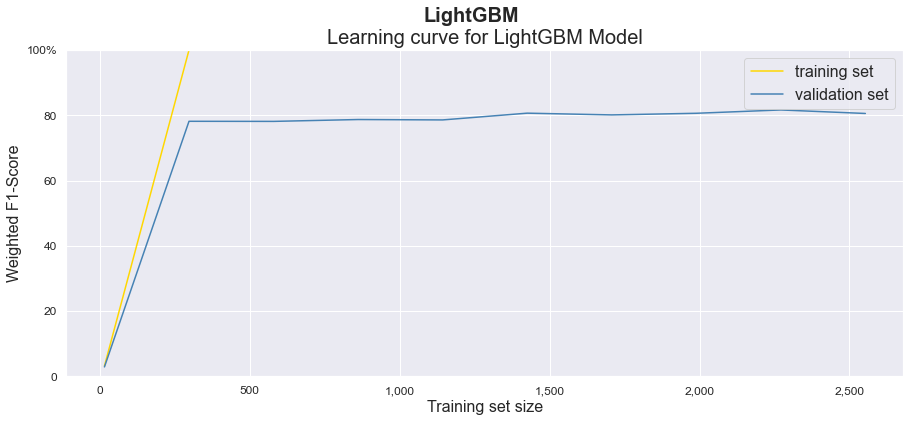

In [183]:
plot_learning_curves(estimator=estimator1,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='LightGBM',
                     title='Learning curve for LightGBM Model',
                     xlabel='Training set size',
                     ylabel='Weighted F1-Score')

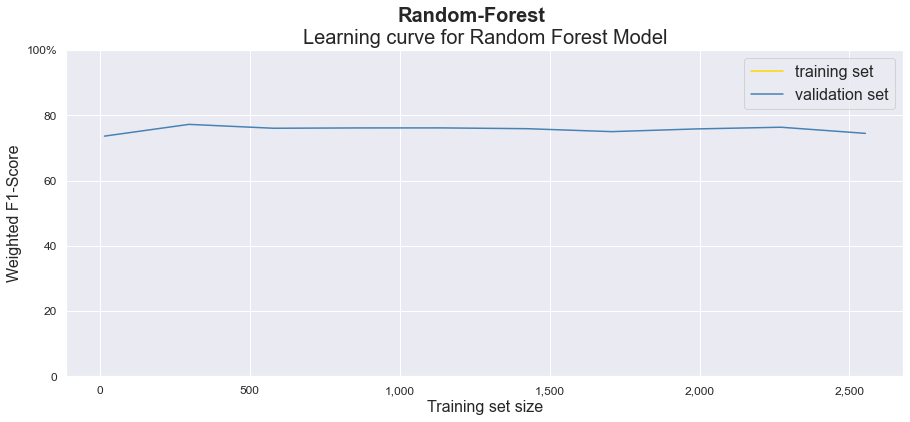

In [184]:
plot_learning_curves(estimator=estimator2,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='Random-Forest',
                     title='Learning curve for Random Forest Model',
                     xlabel='Training set size',
                     ylabel='Weighted F1-Score')

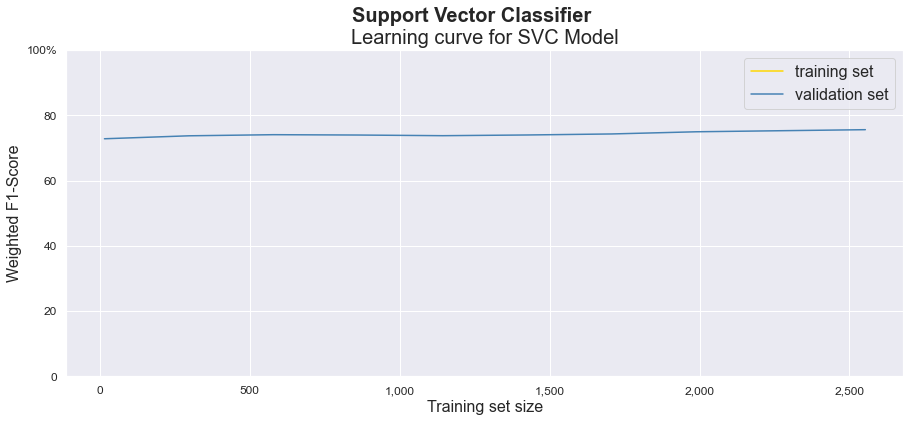

In [185]:
plot_learning_curves(estimator=estimator3,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='Support Vector Classifier',
                     title='Learning curve for SVC Model',
                     xlabel='Training set size',
                     ylabel='Weighted F1-Score')

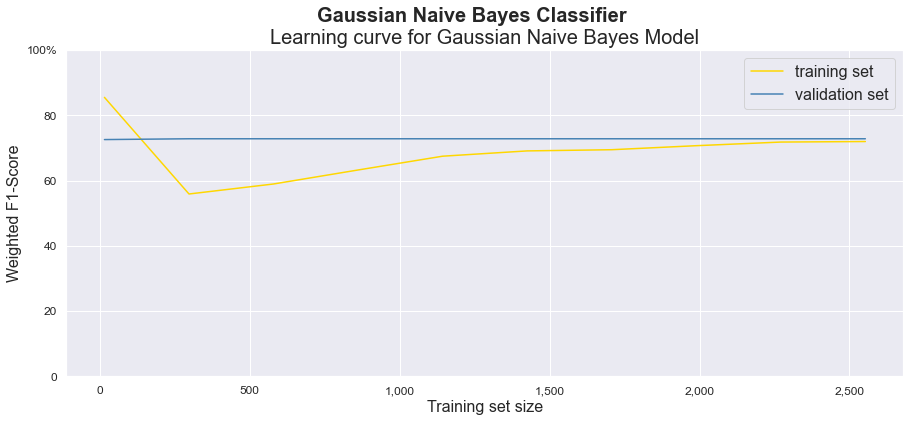

In [186]:
plot_learning_curves(estimator=estimator4,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='Gaussian Naive Bayes Classifier',
                     title='Learning curve for Gaussian Naive Bayes Model',
                     xlabel='Training set size',
                     ylabel='Weighted F1-Score')

**Comparsions**

In [187]:
Model = ["LightGBM", "LightGBM", "LightGBM", "LightGBM",
         "RandomForest", "RandomForest", "RandomForest", "RandomForest",
         "SVC", "SVC", "SVC", "SVC",
         "MultinomialNB", "MultinomialNB", "MultinomialNB", "MultinomialNB"]

Set = ["Validation", "Validation", "Test", "Test",
       "Validation", "Validation", "Test", "Test",
       "Validation", "Validation", "Test", "Test",
       "Validation", "Validation", "Test", "Test"]

Measure = ["Macro-Avgerage", "Weighted-Average", "Macro-Avgerage", "Weighted-Average",
           "Macro-Avgerage", "Weighted-Average", "Macro-Avgerage", "Weighted-Average",
           "Macro-Avgerage", "Weighted-Average", "Macro-Avgerage", "Weighted-Average",
           "Macro-Avgerage", "Weighted-Average", "Macro-Avgerage", "Weighted-Average"]

Score = [e1_valid_cal_macroavg, e1_valid_cal_wavg, e1_test_cal_macroavg, e1_test_cal_wavg,
         e2_valid_cal_macroavg, e2_valid_cal_wavg, e2_test_cal_macroavg, e2_test_cal_wavg,
         e3_valid_cal_macroavg, e3_valid_cal_wavg, e3_test_cal_macroavg, e3_test_cal_wavg,
         e4_valid_cal_macroavg, e4_valid_cal_wavg, e4_test_cal_macroavg, e4_test_cal_wavg]

In [188]:
plot_data = pd.DataFrame([Model, Set, Measure, Score]).transpose()
plot_data.columns = ["Method", "Set", "Measure", "Score"]
plot_data["Score"] = plot_data["Score"].astype(float)

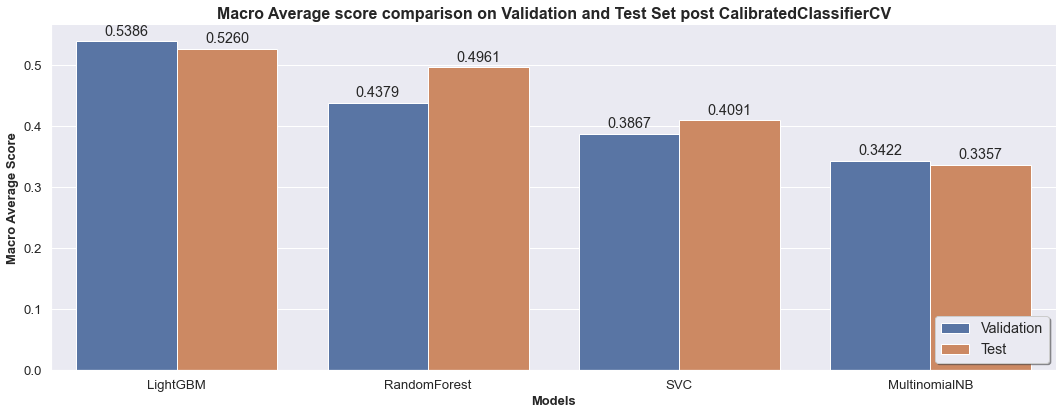

In [189]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(figsize=(15,6))
fig.subplots_adjust(top=0.7)
splot = sns.barplot(x='Method', y="Score", hue="Set", data=plot_data[plot_data['Measure']=="Macro-Avgerage"], ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('Macro Average score comparison on Validation and Test Set post CalibratedClassifierCV', fontsize=16, weight='bold')
axes.set_xlabel('Models', fontsize=13, weight='bold')
axes.set_ylabel('Macro Average Score', fontsize=13, weight='bold')
axes.legend(loc='lower right', shadow=True,fontsize='medium')
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

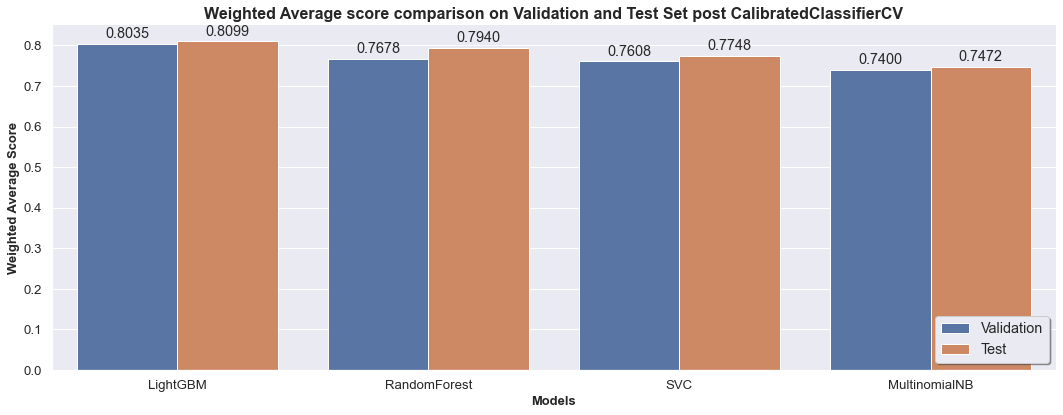

In [190]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(figsize=(15,6))
fig.subplots_adjust(top=0.7)
splot = sns.barplot(x='Method', y="Score", hue="Set", data=plot_data[plot_data['Measure']=="Weighted-Average"], ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('Weighted Average score comparison on Validation and Test Set post CalibratedClassifierCV', fontsize=16, weight='bold')
axes.set_xlabel('Models', fontsize=13, weight='bold')
axes.set_ylabel('Weighted Average Score', fontsize=13, weight='bold')
axes.legend(loc='lower right', shadow=True,fontsize='medium')
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

In [191]:
Model1 = ["LightGBM", "LightGBM", "LightGBM",
         "RandomForest", "RandomForest", "RandomForest",
         "SVC", "SVC", "SVC",
         "MultinomialNB", "MultinomialNB", "MultinomialNB"]

Set1 = ["Class-0", "Class-1", "Class-2",
       "Class-0", "Class-1", "Class-2",
       "Class-0", "Class-1", "Class-2",
       "Class-0", "Class-1", "Class-2"]

Measure1 = ["F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score"]

Score1 = [e1_valid_cal_perclass[0], e1_valid_cal_perclass[1], e1_valid_cal_perclass[2],
            e2_valid_cal_perclass[0], e2_valid_cal_perclass[1], e2_valid_cal_perclass[2],
            e3_valid_cal_perclass[0], e3_valid_cal_perclass[1], e3_valid_cal_perclass[2],
            e4_valid_cal_perclass[0], e4_valid_cal_perclass[1], e4_valid_cal_perclass[2]]

In [192]:
plot_data1 = pd.DataFrame([Model1, Set1, Measure1, Score1]).transpose()
plot_data1.columns = ["Method1", "Set1", "Measure1", "Score1"]
plot_data1["Score1"] = plot_data1["Score1"].astype(float)

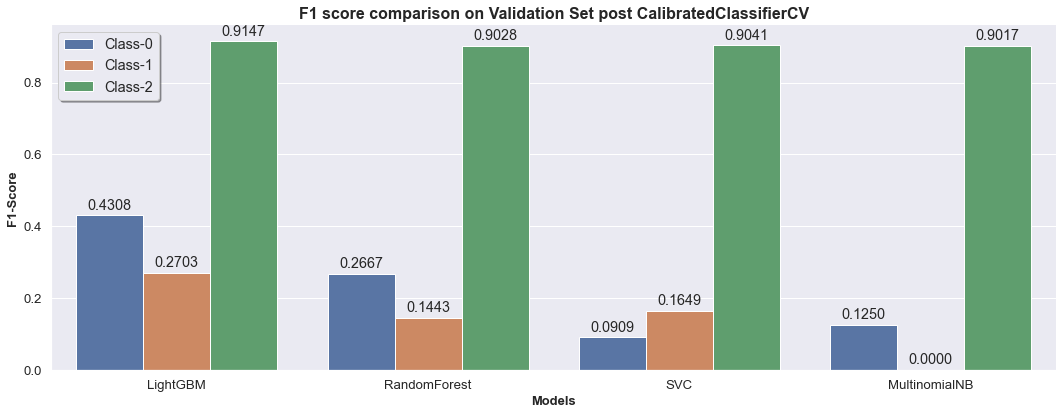

In [193]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(figsize=(15,6))
fig.subplots_adjust(top=0.7)
splot = sns.barplot(x='Method1', y="Score1", hue="Set1", data=plot_data1, ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('F1 score comparison on Validation Set post CalibratedClassifierCV', fontsize=16, weight='bold')
axes.set_xlabel('Models', fontsize=13, weight='bold')
axes.set_ylabel('F1-Score', fontsize=13, weight='bold')
axes.legend(loc='upper left', shadow=True,fontsize='medium')
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

In [194]:
Model2 = ["LightGBM", "LightGBM", "LightGBM",
         "RandomForest", "RandomForest", "RandomForest",
         "SVC", "SVC", "SVC",
         "MultinomialNB", "MultinomialNB", "MultinomialNB"]

Set2 = ["Class-0", "Class-1", "Class-2",
       "Class-0", "Class-1", "Class-2",
       "Class-0", "Class-1", "Class-2",
       "Class-0", "Class-1", "Class-2"]

Measure2 = ["F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score",
           "F1-Score", "F1-Score", "F1-Score"]

Score2 = [e1_test_cal_perclass[0], e1_test_cal_perclass[1], e1_test_cal_perclass[2],
            e2_test_cal_perclass[0], e2_test_cal_perclass[1], e2_test_cal_perclass[2],
            e3_test_cal_perclass[0], e3_test_cal_perclass[1], e3_test_cal_perclass[2],
            e4_test_cal_perclass[0], e4_test_cal_perclass[1], e4_test_cal_perclass[2]]

In [195]:
plot_data2 = pd.DataFrame([Model2, Set2, Measure2, Score2]).transpose()
plot_data2.columns = ["Method2", "Set2", "Measure2", "Score2"]
plot_data2["Score2"] = plot_data2["Score2"].astype(float)

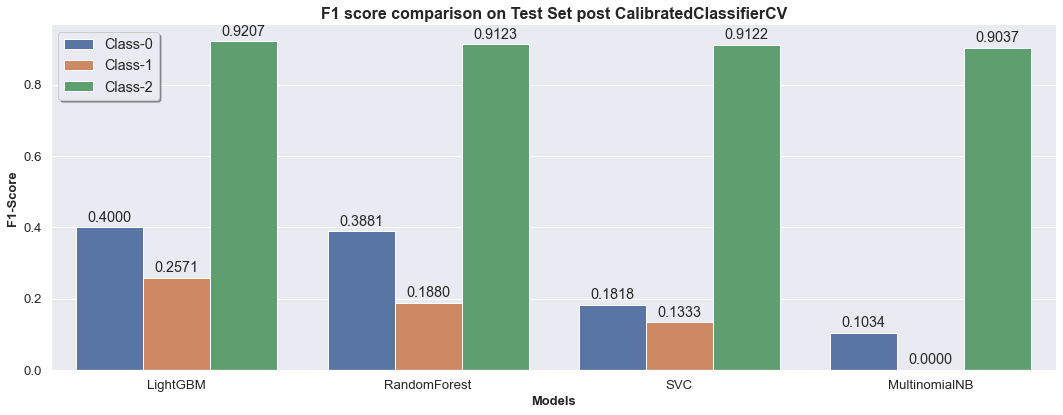

In [196]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(figsize=(15,6))
fig.subplots_adjust(top=0.7)
splot = sns.barplot(x='Method2', y="Score2", hue="Set2", data=plot_data2, ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('F1 score comparison on Test Set post CalibratedClassifierCV', fontsize=16, weight='bold')
axes.set_xlabel('Models', fontsize=13, weight='bold')
axes.set_ylabel('F1-Score', fontsize=13, weight='bold')
axes.legend(loc='upper left', shadow=True,fontsize='medium')
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

**Thank you**